In [1]:
import os, sys, datetime, json, numpy as np
import matplotlib.pyplot as plt

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print(f"Current path: {os.getcwd()}")
sys.path.append('./')

from supervisedlearning.homoskedastic import GaussianProcessRegressorRBF
from supervisedlearning.heteroskedastic import HeteroskedasticGaussianProcessRegressorRBF

from utils import make_json_serializable

Current path: /Users/marcomussi/git/HetGaussianProcesses


In [2]:
kernel_L_lst = [1]
regularization_lst = [10**(- i) for i in range(3, 19)]
regularization_arr = np.array(regularization_lst)
Z_lst = [10, 20, 50, 100, 500]
N_lst = [500]

n_samples_plt = 1000
x_plt = np.linspace(0, 1, n_samples_plt)

HET = "\\hetgp"
HOM = "\\homgp"
alg_lst = [HET, HOM]

def exp_reward_values(xvect):
    return 0.5 * np.ones(xvect.shape) # * np.cos(xvect * 6.28 - 1) + 0.5 
    # costante per testare la stabilità e non la capacità di predizione, 
    # eliminando la possibile critica sulla scelta del kernel

In [3]:
results = {}

for kernel_L in kernel_L_lst:

    print(f"Starting experiment with kernel_L = {kernel_L}")

    results[kernel_L] = {}

    for N in N_lst:
            
        print(f"\tStarting experiment with N = {N}")

        results[kernel_L][N] = {}
        
        for Z in Z_lst:
            
            print(f"\t\tStarting experiment with Z = {Z}")

            results[kernel_L][N][Z] = {}

            # x_plt = np.linspace(0, 1, Z)

            samples_unique = np.linspace(0, 1, Z)
            x_vect = np.repeat(samples_unique, int(N/Z))
            y_vect = exp_reward_values(x_vect)
            x_vect = x_vect.reshape(N, 1)
            y_vect = y_vect.reshape(N, 1)

            results[kernel_L][N][Z][HOM] = {}
            results[kernel_L][N][Z][HOM]["error"] = -1 * np.ones((len(regularization_lst)))
            results[kernel_L][N][Z][HOM]["cond"] = -1 * np.ones((len(regularization_lst), 2))
            results[kernel_L][N][Z][HET] = {}
            results[kernel_L][N][Z][HET]["error"] = -1 * np.ones((len(regularization_lst)))
            results[kernel_L][N][Z][HET]["cond"] = -1 * np.ones((len(regularization_lst), 2))

            for regularization_i, regularization in enumerate(regularization_lst):

                print(f"\t\t\tStarting experiment with regularization = {regularization}")
                
                y_hat = {}
                y_sigma = {}
                
                for alg in alg_lst:

                    if alg == HOM:
                        regressor = GaussianProcessRegressorRBF(kernel_L, regularization)
                    elif alg == HET:
                        regressor = HeteroskedasticGaussianProcessRegressorRBF(kernel_L, regularization)
                    else:
                        raise NotImplementedError(f"{alg} not implemented yet")
                    try:
                        regressor.load_data(x_vect, y_vect)
                        y_hat[alg], y_sigma[alg] = regressor.compute(x_plt.reshape(-1, 1))
                        results[kernel_L][N][Z][alg]["error"][regularization_i] = np.mean(np.power(y_hat[alg] - 0.5, 2))
                        print(f"\t\t\t\tError for {alg} - PosteriorMean: {np.round(results[kernel_L][N][Z][alg]['error'][regularization_i], 5)}")
                    except np.linalg.LinAlgError:
                        results[kernel_L][N][Z][alg]["error"][regularization_i] = np.NaN
                        print(f"\t\t\t\tError for {alg} - Singular Matrix")
                    eigs = regressor.get_eigvals()
                    results[kernel_L][N][Z][alg]["cond"][regularization_i, 0] = min(eigs)
                    results[kernel_L][N][Z][alg]["cond"][regularization_i, 1] = max(eigs)
                    
                """                
                if not np.isnan(results[kernel_L][N][Z][HOM]["error"][regularization_i]) and \
                    not np.isnan(results[kernel_L][N][Z][HET]["error"][regularization_i]):
                    plt.figure()
                    plt.plot(x_plt.ravel(), y_hat[HOM], label=HOM)
                    plt.fill_between(x_plt.ravel(), y_hat[HOM] - y_sigma[HOM], y_hat[HOM] + y_sigma[HOM], alpha=0.3)
                    plt.plot(x_plt.ravel(), y_hat[HET], label=HET)
                    plt.fill_between(x_plt.ravel(), y_hat[HET] - y_sigma[HET], y_hat[HET] + y_sigma[HET], alpha=0.3)
                    plt.plot(x_plt.ravel(), exp_reward_values(x_plt.ravel()), label="RealFun")
                    plt.legend()
                    plt.title(f"N{N}_Z{Z}_reg{regularization}_L{kernel_L}")
                """

Starting experiment with kernel_L = 1
	Starting experiment with N = 500
		Starting experiment with Z = 10
			Starting experiment with regularization = 0.001
				Error for \hetgp - PosteriorMean: 0.0
				Error for \homgp - PosteriorMean: 0.0
			Starting experiment with regularization = 0.0001
				Error for \hetgp - PosteriorMean: 0.0
				Error for \homgp - PosteriorMean: 0.0
			Starting experiment with regularization = 1e-05
				Error for \hetgp - PosteriorMean: 0.0
				Error for \homgp - PosteriorMean: 0.0
			Starting experiment with regularization = 1e-06
				Error for \hetgp - PosteriorMean: 0.0
				Error for \homgp - PosteriorMean: 0.0
			Starting experiment with regularization = 1e-07
				Error for \hetgp - PosteriorMean: 0.0
				Error for \homgp - PosteriorMean: 0.0
			Starting experiment with regularization = 1e-08
				Error for \hetgp - PosteriorMean: 0.0
				Error for \homgp - PosteriorMean: 0.0
			Starting experiment with regularization = 1e-09
				Error for \hetgp - Posterior

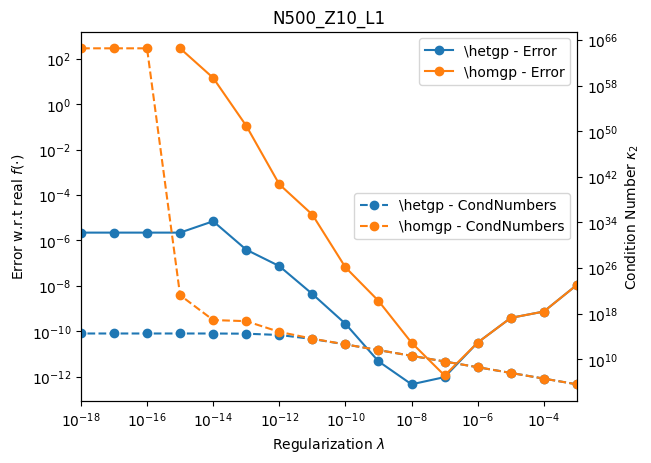

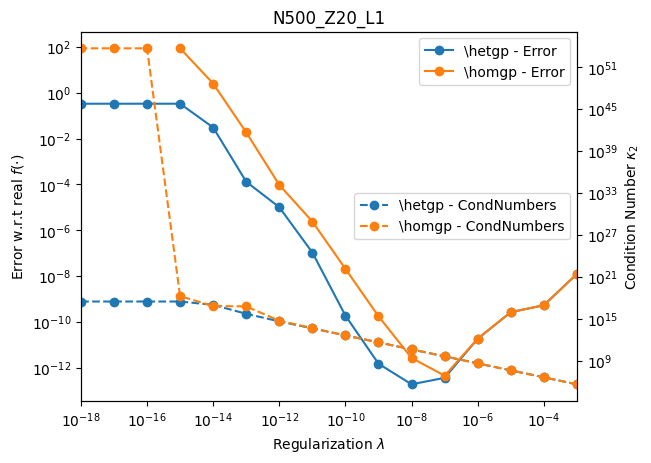

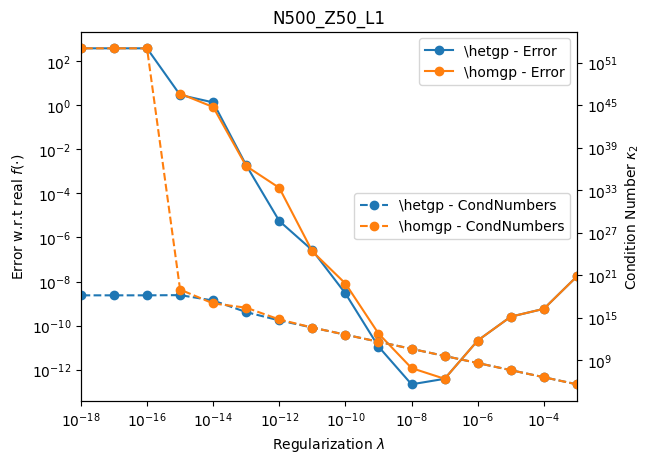

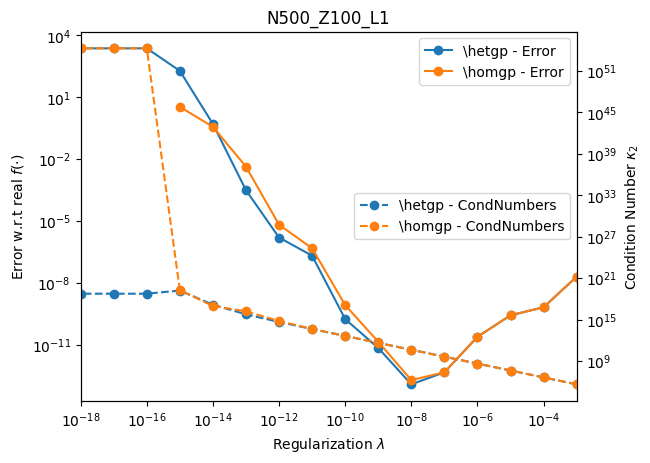

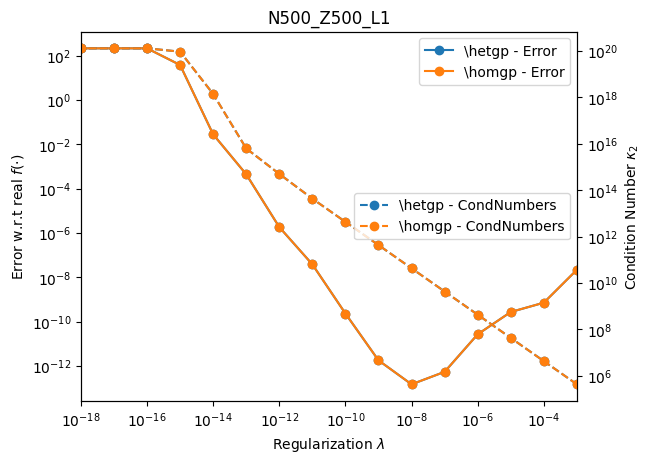

In [4]:
save = True

dateformat = "(%Y-%b-%d %Ih%Mm%p)"
save_path = "results/supervised/stability/"

for kernel_L in kernel_L_lst:
    
    for N in N_lst:
        
        for Z in Z_lst:       
            
            plt.figure()
            mask = {}
            for alg in alg_lst:
                mask[alg] = np.logical_not(np.isnan(results[kernel_L][N][Z][alg]["error"]))
                plt.plot(regularization_arr[mask[alg]], results[kernel_L][N][Z][alg]["error"][mask[alg]], "o-", label=f"{alg} - Error")
            plt.gca().invert_xaxis()
            plt.xscale("log")
            plt.xlim([min(regularization_arr), max(regularization_arr)])
            plt.yscale("log")
            plt.title(f"N{N}_Z{Z}_L{kernel_L}")
            plt.xlabel("Regularization $\lambda$")
            plt.ylabel("Error w.r.t real $f(\cdot)$") 
            plt.legend()
            plt.twinx()
            for alg in alg_lst:
                values = results[kernel_L][N][Z][alg]["cond"][:, 1] / results[kernel_L][N][Z][alg]["cond"][:, 0]
                mask[alg] = np.logical_not(np.isnan(values))
                plt.plot(regularization_arr[mask[alg]], values[mask[alg]], "o--", label=f"{alg} - CondNumbers")
            plt.legend(loc="center right")
            plt.yscale("log")
            plt.ylabel("Condition Number $\kappa_2$") 

            if save:
                complete_path = f"{save_path}Z{Z}_N{N}_L{kernel_L}_algs{alg_lst}_{datetime.datetime.now().strftime(dateformat)}"
                plt.savefig(f"{complete_path}.jpg")
                try:
                    import tikzplotlib as tkz
                    tkz.save(f"{complete_path}.tex")
                except Exception as e:
                    print(f"Error: {e}")
                    print("failed to save in tikz")

serializable_dict = make_json_serializable(results)
complete_path_json = f"{save_path}Zlst{Z_lst}_Nlst{N_lst}_Llst{kernel_L_lst}_REGlst{regularization_lst}_algs{alg_lst}_{datetime.datetime.now().strftime(dateformat)}.json"
with open(complete_path_json, "w", encoding="utf-8") as time_json:
    json.dump(serializable_dict, time_json, ensure_ascii=False, indent=4)